### import important packages

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils import data

import numpy as np

import os
import sys

import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('..'))
from LoadRealRunningJumping import *
from LoadSyntheticRunningJumping import *

from GANModels import *

from dataLoader import *

import torch.fft as fft
from torchsummary import summary

from EvaluationFunctions import DagharUniclassEvaluation

from sklearn.manifold import TSNE

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:55: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


## Load data and GAN generator and discriminator from checkpoint

In [2]:
models_path = '../pre-trained-models/daghar_50000_30_100/'
data_path = '../DAGHAR_GANs/'

original_set = daghar_load_dataset(class_name='run', path=data_path)
syn_set = Single_Class_Synthetic_Dataset(path = models_path +'run_50000_D_30_2024_10_18_01_39_30/Model/' + 'checkpoint',
                                         seq_len=30)

gen_model = Generator(seq_len=30, channels=3).cuda()
running_model = Discriminator(seq_len=30, in_channels=3)
running_ckp = torch.load('../pre-trained-models/daghar_50000_30_100/run_50000_D_30_2024_10_18_01_39_30/Model/checkpoint', map_location=torch.device("cpu"))
running_model.load_state_dict(running_ckp['dis_state_dict'])

return single class data and labels, class is run
data shape is (16260, 3, 1, 30)
label shape is (16260,)
Checkpoint epochs: 50
(600, 3, 1, 30)
(600, 1)


/workspaces/container-workspace/tts-gan/LoadSyntheticRunningJumping.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckp = torch.load(path,  map_location=torch.device('c

<All keys matched successfully>

## Visualize models

In [3]:
summary(gen_model, (1, 3, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1            [-1, 1, 3, 300]          30,300
         LayerNorm-2               [-1, 30, 10]              20
            Linear-3               [-1, 30, 10]             110
            Linear-4               [-1, 30, 10]             110
            Linear-5               [-1, 30, 10]             110
           Dropout-6            [-1, 5, 30, 30]               0
            Linear-7               [-1, 30, 10]             110
MultiHeadAttention-8               [-1, 30, 10]               0
           Dropout-9               [-1, 30, 10]               0
      ResidualAdd-10               [-1, 30, 10]               0
        LayerNorm-11               [-1, 30, 10]              20
           Linear-12               [-1, 30, 40]             440
             GELU-13               [-1, 30, 40]               0
          Dropout-14               [-1,

In [4]:
model = Discriminator(seq_len=30, in_channels=3).cuda()
summary(model, (3, 1, 30))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1                [-1, 2, 45]               0
            Linear-2                [-1, 2, 50]           2,300
PatchEmbedding_Linear-3                [-1, 3, 50]               0
         LayerNorm-4                [-1, 3, 50]             100
            Linear-5                [-1, 3, 50]           2,550
            Linear-6                [-1, 3, 50]           2,550
            Linear-7                [-1, 3, 50]           2,550
           Dropout-8              [-1, 5, 3, 3]               0
            Linear-9                [-1, 3, 50]           2,550
MultiHeadAttention-10                [-1, 3, 50]               0
          Dropout-11                [-1, 3, 50]               0
      ResidualAdd-12                [-1, 3, 50]               0
        LayerNorm-13                [-1, 3, 50]             100
           Linear-14               

## Set discriminator to encoder

In [5]:
keys_to_remove = list(running_ckp['dis_state_dict'].keys())[-4:]  # Obtém as últimas 4 chaves

# Remove as chaves do dicionário original
for key in keys_to_remove:
    del running_ckp['dis_state_dict'][key]

# Verificando o resultado
print(running_ckp['dis_state_dict'].keys())

odict_keys(['0.cls_token', '0.positions', '0.projection.1.weight', '0.projection.1.bias', '1.0.0.fn.0.weight', '1.0.0.fn.0.bias', '1.0.0.fn.1.keys.weight', '1.0.0.fn.1.keys.bias', '1.0.0.fn.1.queries.weight', '1.0.0.fn.1.queries.bias', '1.0.0.fn.1.values.weight', '1.0.0.fn.1.values.bias', '1.0.0.fn.1.projection.weight', '1.0.0.fn.1.projection.bias', '1.0.1.fn.0.weight', '1.0.1.fn.0.bias', '1.0.1.fn.1.0.weight', '1.0.1.fn.1.0.bias', '1.0.1.fn.1.3.weight', '1.0.1.fn.1.3.bias', '1.1.0.fn.0.weight', '1.1.0.fn.0.bias', '1.1.0.fn.1.keys.weight', '1.1.0.fn.1.keys.bias', '1.1.0.fn.1.queries.weight', '1.1.0.fn.1.queries.bias', '1.1.0.fn.1.values.weight', '1.1.0.fn.1.values.bias', '1.1.0.fn.1.projection.weight', '1.1.0.fn.1.projection.bias', '1.1.1.fn.0.weight', '1.1.1.fn.0.bias', '1.1.1.fn.1.0.weight', '1.1.1.fn.1.0.bias', '1.1.1.fn.1.3.weight', '1.1.1.fn.1.3.bias', '1.2.0.fn.0.weight', '1.2.0.fn.0.bias', '1.2.0.fn.1.keys.weight', '1.2.0.fn.1.keys.bias', '1.2.0.fn.1.queries.weight', '1.2.0.fn.1

In [6]:
class Encoder(nn.Sequential):
    def __init__(self, 
                 in_channels=3,
                 patch_size=15,
                 emb_size=50, 
                 seq_len = 150,
                 depth=3, 
                 n_classes=1, 
                 **kwargs):
        super().__init__(
            PatchEmbedding_Linear(in_channels, patch_size, emb_size, seq_len),
            Dis_TransformerEncoder(depth, emb_size=emb_size, drop_p=0.5, forward_drop_p=0.5, **kwargs)
        )

In [ ]:
encoder = Encoder(in_channels=3, seq_len=30).cuda()
summary(encoder, (3, 1, 30))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1                [-1, 2, 45]               0
            Linear-2                [-1, 2, 50]           2,300
PatchEmbedding_Linear-3                [-1, 3, 50]               0
         LayerNorm-4                [-1, 3, 50]             100
            Linear-5                [-1, 3, 50]           2,550
            Linear-6                [-1, 3, 50]           2,550
            Linear-7                [-1, 3, 50]           2,550
           Dropout-8              [-1, 5, 3, 3]               0
            Linear-9                [-1, 3, 50]           2,550
MultiHeadAttention-10                [-1, 3, 50]               0
          Dropout-11                [-1, 3, 50]               0
      ResidualAdd-12                [-1, 3, 50]               0
        LayerNorm-13                [-1, 3, 50]             100
           Linear-14               

In [ ]:
encoder.load_state_dict(running_ckp['dis_state_dict'])

<All keys matched successfully>

## Encoder data visualization

In [18]:
samples = torch.from_numpy(original_set[0:5][0]).float().to('cuda')
print(samples.shape)
forward = encoder(samples)
print(forward.shape)


torch.Size([5, 3, 1, 30])
torch.Size([5, 3, 50])


In [32]:
original_encoder_data = encoder(torch.from_numpy(original_set[:600][0]).float().to('cuda')).cpu().detach().numpy()
synthetic_encoder_data = encoder(torch.from_numpy(syn_set[:600][0]).float().to('cuda')).cpu().detach().numpy()

In [33]:
def TSNE_visualization(original, synthetic, title = 't-SNE plot', show=True, save_path = ''):
        '''

        Data original and synthetic is expected to be in shape (batch, timeframe, channel), for 
        example (600, 30, 3)

        '''
        original = np.transpose(original, (0, 2, 1))
        synthetic = np.transpose(synthetic, (0, 2, 1))

        l = len(original)
        idx = np.random.permutation(l)

        # Data preprocessing
        original = np.asarray(original)
        synthetic = np.asarray(synthetic)  

        original = np.abs(original[idx])
        synthetic = np.abs(synthetic[idx])
            

        no, seq_len, dim = original.shape  

        for i in range(l):
            if (i == 0):
                prep = np.reshape(np.mean(original[0,:,:], 1), [1, seq_len])
                prep_hat = np.reshape(np.mean(synthetic[0,:,:], 1), [1, seq_len])

            else:
                prep = np.concatenate((prep, 
                                            np.reshape(np.mean(original[i,:,:],1), [1, seq_len])))
                prep_hat = np.concatenate((prep_hat, 
                                            np.reshape(np.mean(synthetic[i,:,:],1), [1, seq_len])))
                   
        # Do t-SNE Analysis together       
        prep_data_final = np.concatenate((prep, prep_hat), axis = 0) #(prep, prep_hat, prep_random)
        #print(prep_data_final.shape)

        # TSNE anlaysis
        tsne = TSNE(n_components = 2, verbose = 0, perplexity = 40, n_iter = 300)
        tsne_results = tsne.fit_transform(prep_data_final)
        #print(tsne_results.shape)

        # Plotting
        if not show:
            return tsne_results
            
        f, ax = plt.subplots(1)

        plt.scatter(tsne_results[:l,0], tsne_results[:l,1], 
                        c = 'red', alpha = 0.2, label = "Original")
            
        plt.scatter(tsne_results[l:2*l,0], tsne_results[l:2*l,1], 
                        c = 'blue', alpha = 0.2, label = "Synthetic")
            
        ax.legend()

        plt.title(title)
        plt.xlabel('x-tsne')
        plt.ylabel('y_tsne')
        #plt.savefig(save_path + title + '.png')

        return tsne_results

array([[ 3.9983833,  2.3774724],
       [-6.3009796,  1.689848 ],
       [ 0.6183278, -3.4793534],
       ...,
       [ 1.2609912, -2.158663 ],
       [ 4.878325 , -1.2544813],
       [-7.0959444,  0.9946925]], dtype=float32)

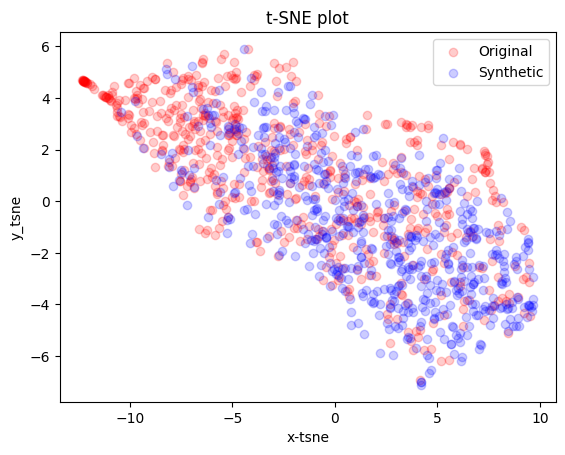

In [34]:
TSNE_visualization(original_encoder_data, synthetic_encoder_data)

In [35]:
import re

# Função para converter até o primeiro número
def convert_string(s):
    # Encontrar a parte da string antes do primeiro número
    match = re.match(r'([^\d]+)(\d+)', s)
    if match:
        # Extrair a parte antes e o número
        prefix = match.group(1).lower()  # Parte antes do número, convertida para minúsculas
        number = match.group(2)          # Primeiro número encontrado
        return f"{prefix}{number}"       # Retorna no formato desejado
    return s  # Retorna a string original se não houver números

models_path = '../pre-trained-models/daghar_split_dataset_50000_30_100/'
data_path = '../DAGHAR_GANs/'
directorys = os.listdir(models_path)
class_names = [s.split('_')[0].lower() for s in directorys]
first_parts = [convert_string(s) for s in directorys]

directorys, class_names, first_parts

(['MotionSense_DAGHAR_Multiclass_50000_D_30_2024_10_25_00_00_24',
  'UCI_DAGHAR_Multiclass_50000_D_30_2024_10_25_01_37_21',
  'WISDM_DAGHAR_Multiclass_50000_D_30_2024_10_25_01_05_31',
  'RealWorld_thigh_DAGHAR_Multiclass_50000_D_30_2024_10_25_00_33_27',
  'RealWorld_waist_DAGHAR_Multiclass_50000_D_30_2024_10_25_02_11_06',
  'KuHar_DAGHAR_Multiclass_50000_D_30_2024_10_25_02_42_43'],
 ['motionsense', 'uci', 'wisdm', 'realworld', 'realworld', 'kuhar'],
 ['motionsense_daghar_multiclass_50000',
  'uci_daghar_multiclass_50000',
  'wisdm_daghar_multiclass_50000',
  'realworld_thigh_daghar_multiclass_50000',
  'realworld_waist_daghar_multiclass_50000',
  'kuhar_daghar_multiclass_50000'])